## 0. Import Libraries

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from xclim import sdba
from glob import glob
from shapely.geometry import mapping

import xclim
import utils


%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


https://xclim.readthedocs.io/en/stable/notebooks/sdba.html

### 0.1 Exercises (Redundant)

In [2]:
t = xr.cftime_range("2000-01-01", "2030-12-31", freq="D", calendar="noleap")

In [3]:
vals = np.random.randint(0, 1000, size=(t.size,)) / 100
vals_ref = (4 ** np.where(vals < 9, vals / 100, vals)) / 3e6
vals_sim = (
    (1 + 0.1 * np.random.random_sample((t.size,)))
    * (4 ** np.where(vals < 9.5, vals / 100, vals))
    / 3e6
)

pr_ref = xr.DataArray(
    vals_ref, coords={"time": t}, dims=("time",), attrs={"units": "mm/day"}
)
pr_ref = pr_ref.sel(time=slice("2000", "2015"))
pr_sim = xr.DataArray(
    vals_sim, coords={"time": t}, dims=("time",), attrs={"units": "mm/day"}
)
pr_hist = pr_sim.sel(time=slice("2000", "2015"))

In [4]:
pr_hist

<xarray.DataArray (time: 5840)>
array([3.82309250e-07, 2.47231004e-01, 3.57477160e-07, ...,
       3.91664883e-07, 3.50336049e-07, 3.85657170e-07])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 00:00:00
Attributes:
    units:    mm/day

In [5]:
pr_sim

<xarray.DataArray (time: 11315)>
array([3.82309250e-07, 2.47231004e-01, 3.57477160e-07, ...,
       3.56126037e-07, 3.75042708e-07, 4.08203691e-07])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:    mm/day

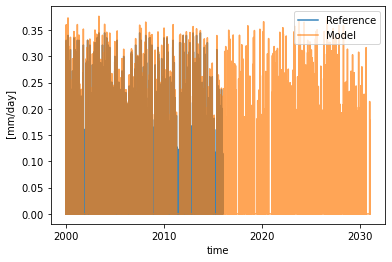

In [6]:
pr_ref.plot(alpha=0.9, label="Reference")
pr_sim.plot(alpha=0.7, label="Model")
plt.legend()

In [7]:
QM = sdba.EmpiricalQuantileMapping.train(pr_ref, pr_hist, nquantiles=15, kind="*", group="time")

In [8]:
scen = QM.adjust(pr_sim)

In [10]:
pr_sim

<xarray.DataArray (time: 11315)>
array([3.82309250e-07, 2.47231004e-01, 3.57477160e-07, ...,
       3.56126037e-07, 3.75042708e-07, 4.08203691e-07])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:    mm d-1

In [18]:
scen_single = QM.adjust(pr_sim[-100:])

In [22]:
QM.ds.af

<xarray.DataArray 'af' (group: 1, quantiles: 15)>
array([[9.75031131e-01, 9.62698858e-01, 9.57974063e-01, 9.55625349e-01,
        9.53690951e-01, 9.54751877e-01, 9.54133927e-01, 9.52794039e-01,
        9.52409635e-01, 9.52008611e-01, 9.50360988e-01, 9.48842627e-01,
        9.44231995e-01, 2.16432385e+04, 9.56025534e-01]])
Coordinates:
  * quantiles  (quantiles) float64 0.03333 0.1 0.1667 ... 0.8333 0.9 0.9667
  * group      (group) int64 1
Attributes:
    units:          mm d-1
    kind:           *
    standard_name:  Adjustment factors
    long_name:      Quantile mapping adjustment factors

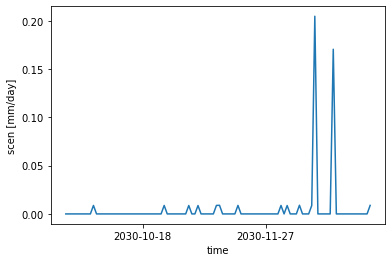

In [19]:
scen_single.plot()

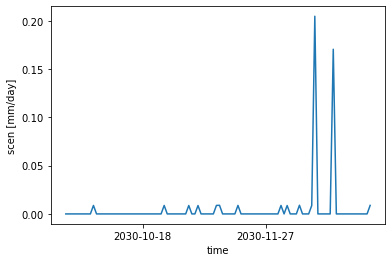

In [20]:
scen[-100:].plot()

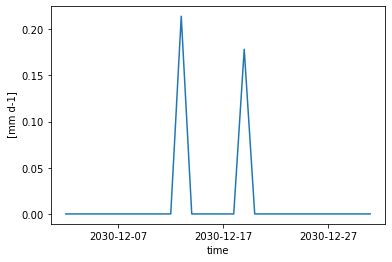

In [14]:
pr_sim[-30:].plot()

In [18]:
QM.ds

<xarray.Dataset>
Dimensions:    (quantiles: 15, group: 1)
Coordinates:
  * quantiles  (quantiles) float64 0.03333 0.1 0.1667 ... 0.8333 0.9 0.9667
  * group      (group) int64 1
Data variables:
    af         (group, quantiles) float64 0.9748 0.965 ... 2.196e+05 0.9546
    hist_q     (group, quantiles) float64 3.436e-07 3.505e-07 ... 0.2297
Attributes:
    group:               time
    group_compute_dims:  ['time']
    group_window:        1
    _xclim_adjustment:   {"py/object": "xclim.sdba.adjustment.EmpiricalQuanti...
    adj_params:          EmpiricalQuantileMapping(group=Grouper(name='time'),...

## 1. Open Data (to be adjusted)

In [3]:
# change if needed
bias_algo = 'QDM_era5land' # EQM or QDM or QDM_era5land
season = 'JJA' # DJF or JJA
time_frame = '208101_210012' # 206101_208012 or 208101_210012 for proj or 198501_200512 for reference

path_general = r'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data'
path_coeff = r'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/data/bias_correction'

#### 1.1.1 Model

#### 1.1.2 Vector Data

In [4]:
turkey_bool = xr.open_dataset(fr"{path_general}/data/TOT_PREC/cosmo/BC/vectorized_turkey_mask_from_era5land.nc")

dt_model = xr.open_dataset(fr'{path_general}/cosmo/yearly/Tr011_MPI_RF_PR_{season}_1hr_198501_200512.nc',
                           chunks={"rlon": 10, "rlat":10} # 20 için %56 da patladı, 15 için %55
                     )

In [5]:
# burada yıl ayarı
year_range = np.arange(int(time_frame[0:4]), 
                       int(time_frame[7:11])+1)
yearly_paths = glob(fr'{path_general}/cosmo/yearly/Tr011_MPI_RF_PR_{season}_1hr*')
yearly_paths = [expected_path for expected_path in yearly_paths 
                              if int(expected_path[-7:-3]) >= int(time_frame[0:4]) 
                              and int(expected_path[-7:-3]) <= int(time_frame[7:11])
               ]
yearly_paths

['/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2081.nc',
 '/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2082.nc',
 '/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2083.nc',
 '/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2084.nc',
 '/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2085.nc',
 '/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2086.nc',
 '/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2087.nc',
 '/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2088.nc',
 '/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2089.nc',
 '/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2090.nc',
 '/mnt/e/JupyterLab/Yuksek_Lis

## 2. Adjust Model With Quantile Mapping

### 2.1 Open Coefficient Data

In [6]:
coeff = xr.open_dataset(fr'{path_coeff}/{bias_algo}_coefficients_{season}.nc')

In [7]:
QM = sdba.QuantileDeltaMapping.from_dataset(coeff)

In [8]:
QM

QuantileDeltaMapping(group=Grouper(name='time'), kind='*')

### 2.2 Ajust Coefficient Data

In [9]:
wet_hour_mm = 0.1

for year, year_path in enumerate(yearly_paths):
        
    # open data
    dt_model = xr.open_dataset(year_path)

    print('data open')

    # adjust model
    dt_model['TOT_PREC'] = dt_model['TOT_PREC'].where(dt_model['TOT_PREC']>wet_hour_mm, 
                                            0.05
                                           )
    
    # addition with era5land
    dt_model = dt_model['TOT_PREC'].where(turkey_bool==1)
    dt_model = dt_model.rename({'Tw':'TOT_PREC'})

    # adjust and save the data
    QM.adjust(dt_model['TOT_PREC'], interp='linear')\
      .to_netcdf(fr"{path_general}/cosmo/yearly/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_1hr_{year_range[year]}.nc")

    print(year_path)

data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2081.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2082.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2083.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2084.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2085.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2086.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2087.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2088.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2089.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2090.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2091.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2092.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2093.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2094.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2095.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2096.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2097.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2098.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2099.nc
data open


/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/Tr011_MPI_RF_PR_JJA_1hr_2100.nc


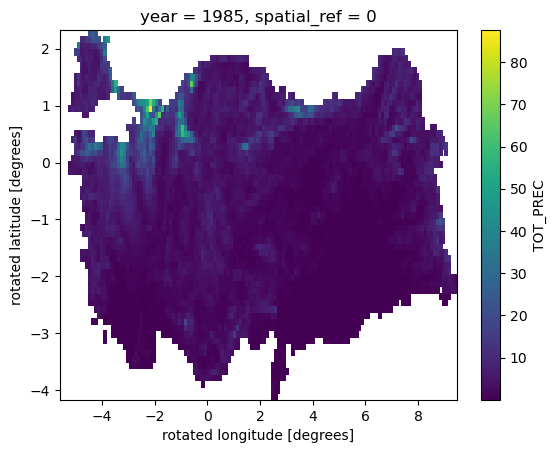

In [14]:
dt_model['TOT_PREC'].max(dim='time').plot()

In [11]:
jj = xr.open_dataset(fr"{path_general}/cosmo/yearly/BC/BC_QDM_era5land_Tr011_MPI_RF_PR_{season}_1hr_2100.nc")

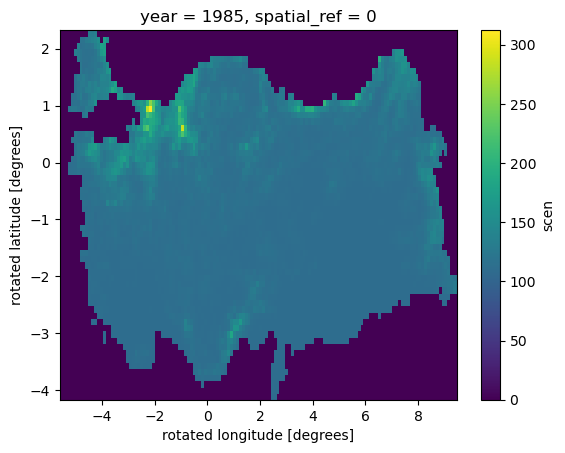

In [12]:
# era5land
jj.transpose('time', 'rlat', 'rlon')['scen'].sum(dim='time').plot()

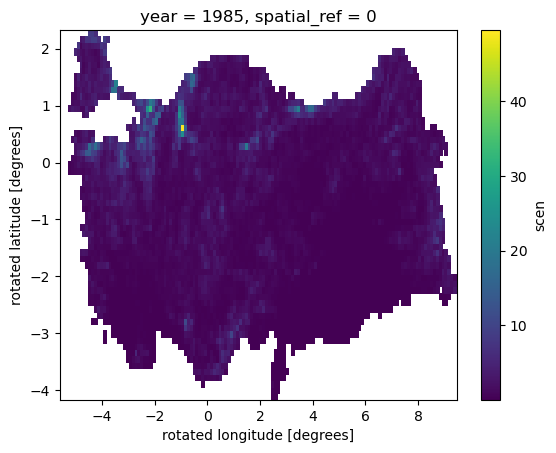

In [13]:
# era5
jj.transpose('time', 'rlat', 'rlon')['scen'].max(dim='time').plot()

## 3. Check Accuracy

In [13]:
jj = xr.open_dataset(fr"{path_general}/cosmo/yearly/BC/BC_QDM_era5land_Tr011_MPI_RF_PR_{season}_1hr_1985.nc")

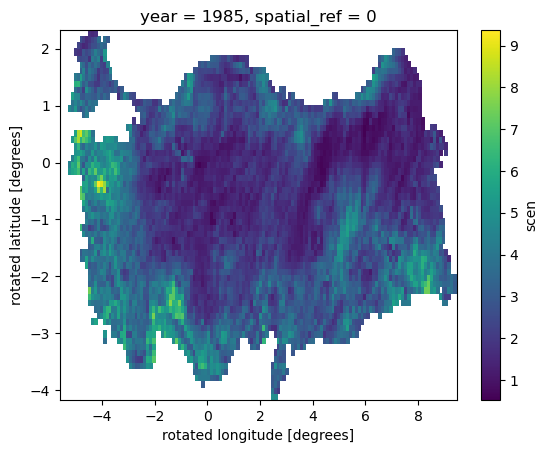

In [24]:
# era5
jj.transpose('time', 'rlat', 'rlon')['scen'].max(dim='time').plot()

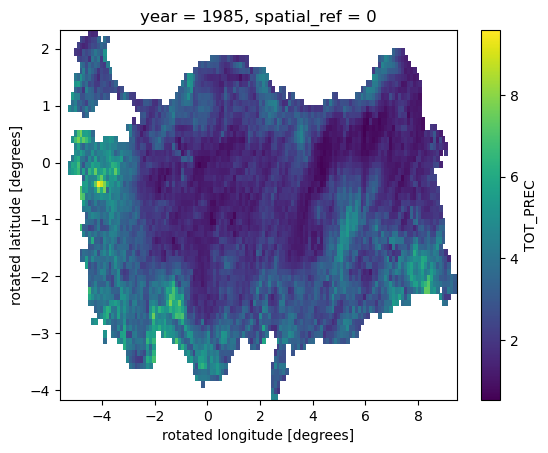

In [36]:
# era5land
jj = jj.transpose('time', 'rlat', 'rlon')['scen'].where(turkey_bool==1)
jj = jj.rename({'Tw':'TOT_PREC'})
jj['TOT_PREC'].max(dim='time').plot()

In [29]:
jj

<xarray.Dataset>
Dimensions:      (time: 2160, rlat: 59, rlon: 137)
Coordinates:
  * time         (time) datetime64[ns] 1985-01-01 ... 1985-12-31T23:00:00
  * rlon         (rlon) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * rlat         (rlat) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    lat          (rlat, rlon) float32 35.68 35.69 35.69 ... 41.63 41.62 41.6
    lon          (rlat, rlon) float32 26.18 26.31 26.45 ... 45.33 45.47 45.62
    year         int64 ...
    spatial_ref  int64 ...
Data variables:
    TOT_PREC     (time, rlat, rlon) float64 nan nan nan nan ... nan nan nan nan

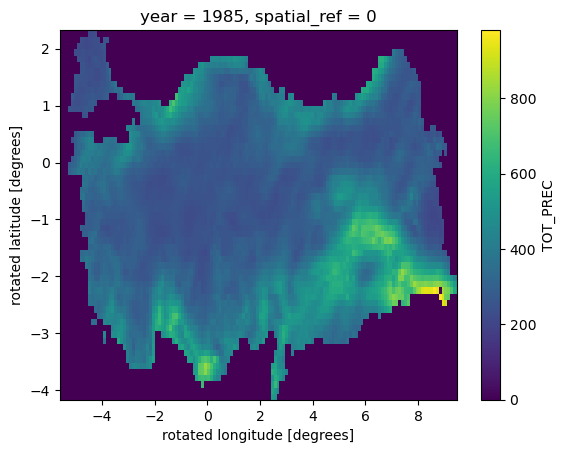

In [37]:
# era5land
jj['TOT_PREC'].sum(dim='time').plot()

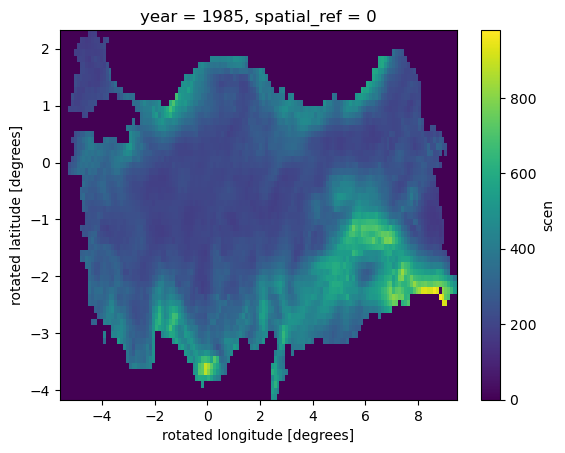

In [39]:
# era5
jj.transpose('time', 'rlat', 'rlon')['scen'].sum(dim='time').plot()

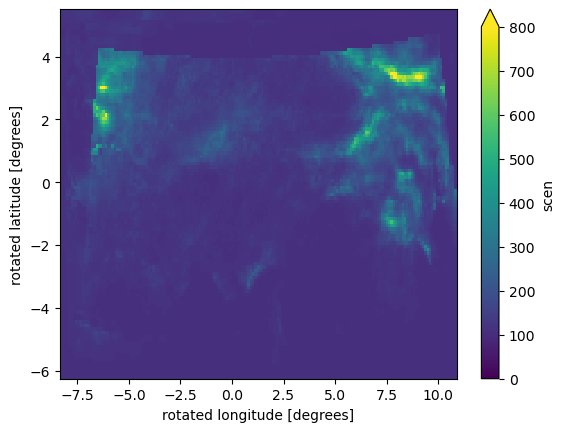

In [17]:
# era5land
jj.transpose('time', 'rlat', 'rlon')['scen'].sum(dim='time').plot(vmin=0, vmax=800)

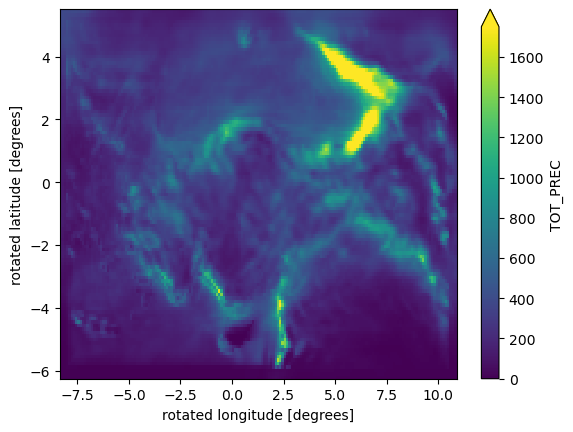

In [91]:
dt_model = xr.open_dataset(yearly_paths[0])
dt_model['TOT_PREC'].sum(dim='time').plot(vmin=0, vmax=1750)

In [61]:
pat

<xarray.Dataset>
Dimensions:       (time: 2160, bnds: 2, rlat: 107, rlon: 175)
Coordinates:
  * time          (time) datetime64[ns] 2099-01-01 ... 2099-12-31T23:00:00
    lon           (rlat, rlon) float32 ...
    lat           (rlat, rlon) float32 ...
  * rlon          (rlon) float32 -8.3 -8.19 -8.08 -7.97 ... 10.62 10.73 10.84
  * rlat          (rlat) float32 -6.2 -6.09 -5.98 -5.87 ... 5.13 5.24 5.35 5.46
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] ...
    rotated_pole  |S1 ...
    TOT_PREC      (time, rlat, rlon) float32 0.05 0.05 0.05 ... 0.05 0.05 0.05
Attributes: (12/14)
    CDI:                       Climate Data Interface version 1.9.10 (https:/...
    Conventions:               CF-1.4
    source:                    /home/marmara/cclm-sp-v3.1.1/src/cclm/cclm.exe}
    title:                     CCLM_v5.0_clm16 Simulation (0.11 Deg) with Med...
    experiment_id:             Tr0.11_RCP8.5
    realization:               1
    ...                        ...
    references:                http://www.clm-community.eu/
    creation_date:             2020-10-18 09:06:50
    NCO:                       4.7.2
    nco_openmp_thread_number:  1
    history:                   Tue Mar 21 18:08:21 2023: cdo -select,season=D...
    CDO:                       Climate Data Operators version 1.9.10 (https:/...

## miscallenous

from dask.diagnostics import ProgressBar

delayed_obj = dt_model_qm.to_netcdf(fr"{path_general}/cosmo/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_1hr_{year_range[t]}.nc",
                                       compute=False)

with ProgressBar():
    results = dt_model_qm.compute()

## 4. Merge Individiual Datasets

bc_paths = glob(fr'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_1hr*.nc')

dt_to_be_merged = xr.open_mfdataset(bc_paths).rename({'scen':'TOT_PREC'})

dt_to_be_merged

dt_to_be_merged.to_netcdf(fr'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_1hr_198501_200512.nc')

In [2]:
import xarray as xr
ll = xr.open_dataset(r'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data/cosmo/yearly/BC/BC_QDM_Tr011_MPI_RF_PR_DJF_1hr_merged_198501_200512.nc',
               chunks={"rlon": 20, "rlat":20})

In [10]:
import numpy as np
np.unique(ll['time.month'])

array([ 1,  2, 12])

In [19]:
lll = ll['scen'].resample(time='1Y').sum().quantile(0.9, dim='year').plot()

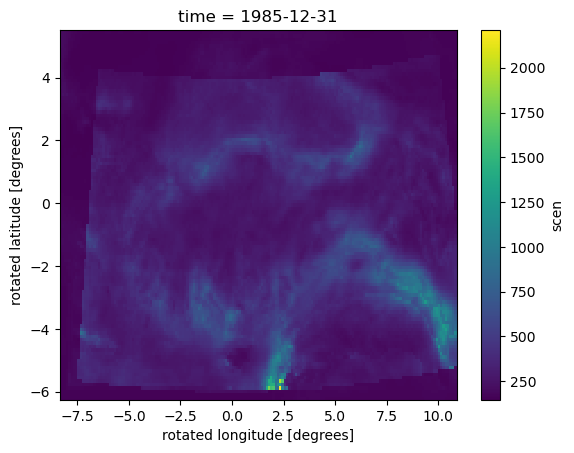

In [21]:
lll[0].plot()